Authors : Kilian Raude, Colin Pelletier, Joris Monnet

# Data exploration

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import csv

# import self-defined modules
sys.path.append("../")
sys.path.append("../src/")

from src.implementations import *
from src.helpers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
DATA_FOLDER = "../data/"
TRAIN_FILE = "train.csv"
TEST_FILE = "test.csv"
IS_DEBUG = True
NAN_VALUE = -999.0
INTEGER_COLUMN = (
    22  # 24 in raw csv file, but 23 when id and prediction column are removed
)

# For debug purpose only
SUB_SAMPLE = False

# Import dataset

In [3]:
# Load data
y_tr, x_tr, _ = load_csv_data(DATA_FOLDER + TRAIN_FILE, sub_sample=SUB_SAMPLE)
y_te, x_te, ids_tests = load_csv_data(DATA_FOLDER + TEST_FILE, sub_sample=SUB_SAMPLE)
print("x_tr shape : {}, y_tr shape : {}".format(x_tr.shape, y_tr.shape))
print("x_te shape : {}, y_te shape : {}".format(x_te.shape, y_te.shape))

# Define missing values as NAN
x_tr[x_tr == NAN_VALUE] = np.nan
x_te[x_te == NAN_VALUE] = np.nan

x_tr shape : (250000, 30), y_tr shape : (250000,)
x_te shape : (568238, 30), y_te shape : (568238,)


## Labels distributions

Signals: 85667 (34.2668%)
Backgrounds: 164333 (65.7332%)
Ratio signal / background: 0.521301260245964


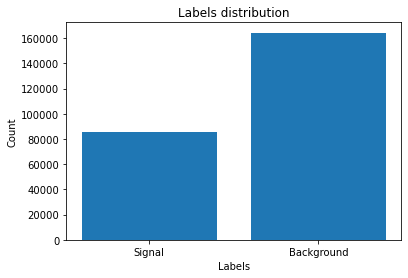

In [4]:
nb_s = len(y_tr[y_tr == 1])
nb_b = len(y_tr) - nb_s
print("Signals: {} ({}%)".format(nb_s, 100 * nb_s / len(x_tr)))
print("Backgrounds: {} ({}%)".format(nb_b, 100 * nb_b / len(x_tr)))
print("Ratio signal / background: {}".format(nb_s / nb_b))

plt.bar(["Signal", "Background"], [nb_s, nb_b])
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Labels distribution")
plt.show()

## NAN values

In [5]:
MAX_NAN_RATIO = 0.5

nb_nan = np.count_nonzero(np.isnan(x_tr), axis=0)
nan_ratio = nb_nan / x_tr.shape[0]

print(
    "Nb Columns with > {:.2f} nan ratio : {}".format(
        MAX_NAN_RATIO, np.count_nonzero(nan_ratio >= MAX_NAN_RATIO)
    )
)

col_names = []
with open(DATA_FOLDER + TRAIN_FILE) as dataset:
    col_names = dataset.readline().split(",")
    nan_col_names = [
        col_name
        for col_idx, col_name in enumerate(col_names[2:])
        if nan_ratio[col_idx] >= MAX_NAN_RATIO
    ]

    print("Columns with > {:.2f} nan ratio :".format(MAX_NAN_RATIO))
    print(nan_col_names)

Nb Columns with > 0.50 nan ratio : 7
Columns with > 0.50 nan ratio :
['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi']


## Features distributions

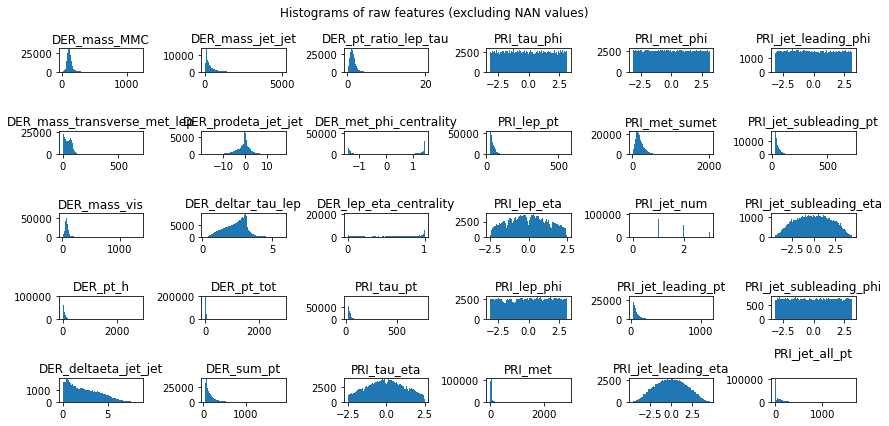

In [6]:
fig, axs = plt.subplots(5, 6, sharex=False, sharey=False, figsize=(12, 6))

fig.suptitle("Histograms of raw features (excluding NAN values)")

# don't select nan values
for col_idx in range(len(col_names) - 2):
    subplt = axs[col_idx % 5, math.floor(col_idx / 5)]

    col = x_tr[:, col_idx]
    subplt.hist(col[~np.isnan(col)], bins=100)
    subplt.set_title(col_names[col_idx + 2])

plt.tight_layout()
plt.show()

## In depth feature analysis
Select one feature at the beginning of the cell (col_name_to_plot). Then, run the cell above and the following ones to analyse this feature in details.

(250000,)
(249999,)


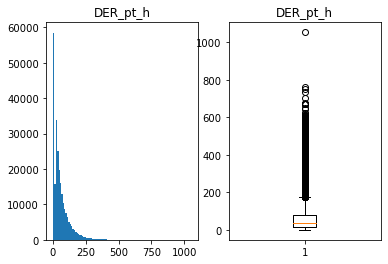

min: 0.0, max: 1053.807
argmin: 6483, argmax: 68116


In [7]:
is_in_depth = True

if is_in_depth:
    # select the feature to plot
    col_name_to_plot = "DER_pt_h"
    col_idx_to_plot = get_col_idx(col_name_to_plot, col_names)

    col_to_plot = x_tr[:, col_idx_to_plot].copy()
    print(col_to_plot.shape)

    col_to_plot = np.delete(col_to_plot, (7343), axis=0)
    print(col_to_plot.shape)

    # plot distribution
    fig, axs = plt.subplots(1, 2)
    axs[0].hist(col_to_plot[~np.isnan(col_to_plot)], bins=100)
    axs[0].set_title(col_name_to_plot)

    col_nan = col_to_plot[~np.isnan(col_to_plot)]
    axs[1].boxplot(col_to_plot[~np.isnan(col_to_plot)])
    axs[1].set_title(col_name_to_plot)

    plt.show()

    print("min: {}, max: {}".format(col_to_plot.min(), col_to_plot.max()))
    print("argmin: {}, argmax: {}".format(col_to_plot.argmin(), col_to_plot.argmax()))

    # features_to_log_transform = ['DER_pt_h', 'DER_pt_tot', 'PRI_met', 'PRI_met_sumet]

Transform the feature

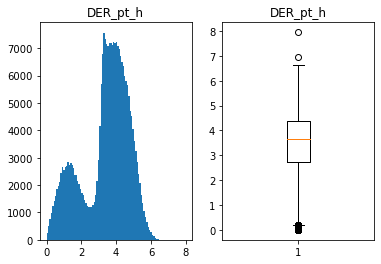

min: 0.0, max: 7.950149535042647
argmin: 6483, argmax: 7343


In [8]:
if is_in_depth:
    col_to_plot = x_tr[:, col_idx_to_plot].copy()

    col_to_plot = np.log(col_to_plot + 1)

    # plot distribution
    fig, axs = plt.subplots(1, 2)
    axs[0].hist(col_to_plot[~np.isnan(col_to_plot)], bins=100)
    axs[0].set_title(col_name_to_plot)

    col_nan = col_to_plot[~np.isnan(col_to_plot)]
    axs[1].boxplot(col_to_plot[~np.isnan(col_to_plot)])
    axs[1].set_title(col_name_to_plot)

    plt.show()

    print("min: {}, max: {}".format(col_to_plot.min(), col_to_plot.max()))
    print("argmin: {}, argmax: {}".format(col_to_plot.argmin(), col_to_plot.argmax()))

Test if the feature follows a power law

In [9]:
# if is_in_depth:
#     array_cumulative=plt.hist(col_to_plot,bins=100,log=True,cumulative=-1,histtype='step')
#     plt.title('Histogram of Population (cumulative)')
#     plt.ylabel('# of cantons (in log scale)')
#     plt.xlabel('population')
#     plt.show()

#     plt.loglog(array_cumulative[1][1:],array_cumulative[0])
#     plt.title('Histogram of Population (cumulative)')
#     plt.ylabel('# of cantons (in log scale)')
#     plt.xlabel('population (in log scale)')
#     plt.show()

## Problematic features analysis
Some features have been empricially defined as problematic. The problem is that after standardization, those features values will highly differ between the training and the test set, due the the presence of an outliers.
The histograms and statistics below allows us to understand which features are problematic.  
Using this technique, the sample 7343 has been identified as an outlier.

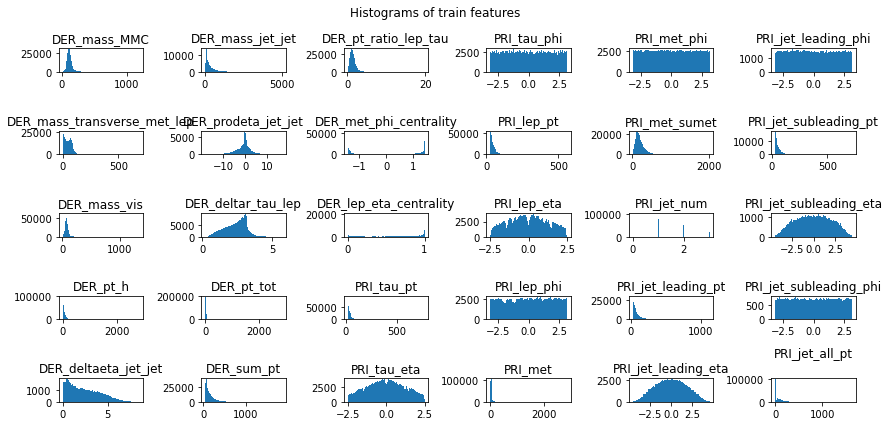

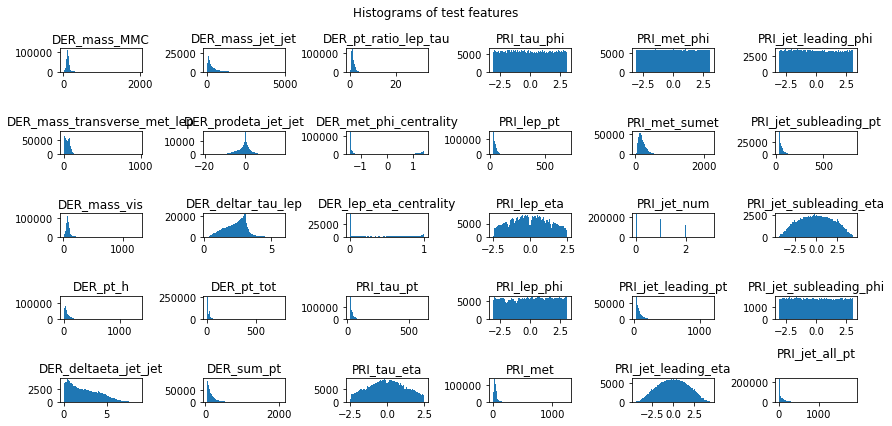

In [10]:
fig, axs = plt.subplots(5, 6, sharex=False, sharey=False, figsize=(12, 6))

fig.suptitle("Histograms of train features")

# don't select nan values
for col_idx in range(x_tr.shape[1]):
    subplt = axs[col_idx % 5, math.floor(col_idx / 5)]

    col = x_tr[:, col_idx]
    subplt.hist(col[~np.isnan(col)], bins=100)
    subplt.set_title(col_names[col_idx + 2])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(5, 6, sharex=False, sharey=False, figsize=(12, 6))

fig.suptitle("Histograms of test features")

# don't select nan values
for col_idx in range(x_tr.shape[1]):
    subplt = axs[col_idx % 5, math.floor(col_idx / 5)]

    col = x_te[:, col_idx]
    subplt.hist(col[~np.isnan(col)], bins=100)
    subplt.set_title(col_names[col_idx + 2])


plt.tight_layout()
plt.show()

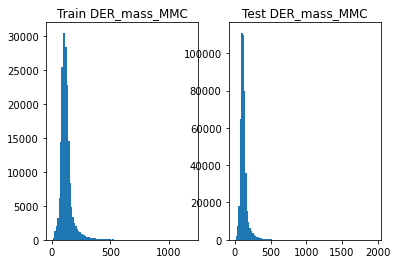

Train:
min: 9.044, max: 1192.026
argmin: 37915, argmax: 128592
Test:
min: 9.112, max: 1949.261
argmin: 371021, argmax: 422933


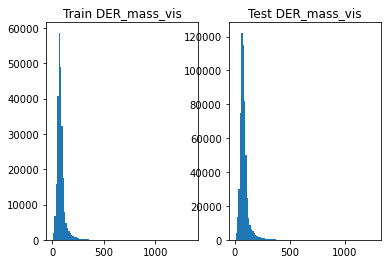

Train:
min: 6.329, max: 1349.351
argmin: 71884, argmax: 202795
Test:
min: 6.81, max: 1264.965
argmin: 137433, argmax: 103064


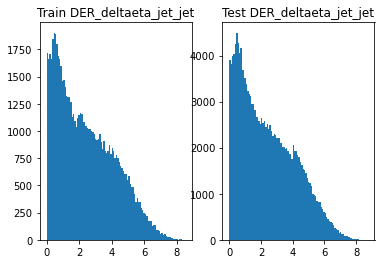

Train:
min: 0.0, max: 8.503
argmin: 11801, argmax: 51548
Test:
min: 0.0, max: 8.724
argmin: 5382, argmax: 34100


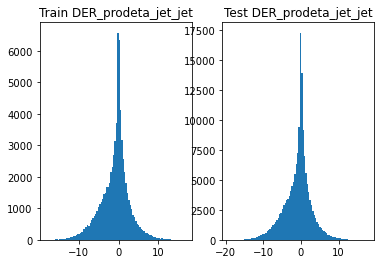

Train:
min: -18.066, max: 16.69
argmin: 51548, argmax: 27532
Test:
min: -19.012, max: 17.65
argmin: 34100, argmax: 162213


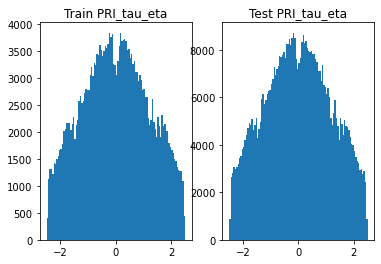

Train:
min: -2.499, max: 2.497
argmin: 171363, argmax: 184119
Test:
min: -2.499, max: 2.5
argmin: 44356, argmax: 292921


In [11]:
problematic_features = (
    "DER_mass_MMC",
    "DER_mass_vis",
    "DER_deltaeta_jet_jet",
    "DER_prodeta_jet_jet",
    "PRI_tau_eta",
)

for col_name in problematic_features:
    col_idx = get_col_idx(col_name, col_names)

    fig, axs = plt.subplots(1, 2)

    # plot train distribution
    col_tr = x_tr[:, col_idx].copy()
    col_tr = col_tr[~np.isnan(col_tr)]

    axs[0].hist(col_tr, bins=100)
    axs[0].set_title("Train {}".format(col_name))

    # plot test distribution
    col_te = x_te[:, col_idx].copy()
    col_te = col_te[~np.isnan(col_te)]

    axs[1].hist(col_te, bins=100)
    axs[1].set_title("Test {}".format(col_name))

    plt.show()

    # basic stats
    print("Train:")
    print("min: {}, max: {}".format(col_tr.min(), col_tr.max()))
    print("argmin: {}, argmax: {}".format(col_tr.argmin(), col_tr.argmax()))

    print("Test:")
    print("min: {}, max: {}".format(col_te.min(), col_te.max()))
    print("argmin: {}, argmax: {}".format(col_te.argmin(), col_te.argmax()))

# Feature engineering / Data cleaning

In [12]:
print("x_tr range :{} {}".format(np.nanmin(x_tr), np.nanmax(x_tr)))
print("x_te range :{} {}".format(np.nanmin(x_te), np.nanmax(x_te)))

x_tr range :-18.066 4974.979
x_te range :-19.012 4794.827


### Logarithmic feature transformation

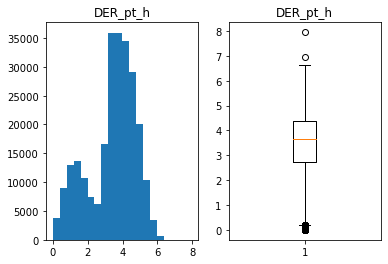

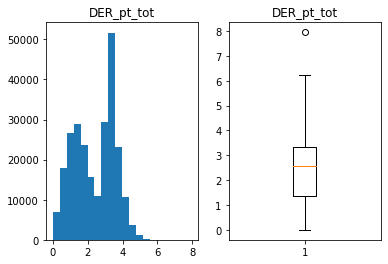

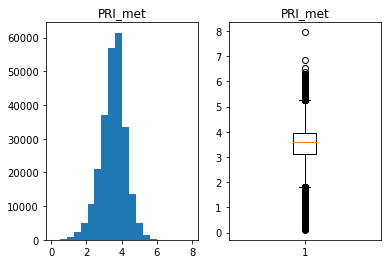

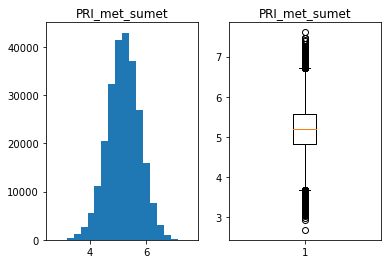

In [13]:
xtr = x_tr.copy()
xte = x_te.copy()

cols_to_log_transform = ["DER_pt_h", "DER_pt_tot", "PRI_met", "PRI_met_sumet"]
cols_idx = [get_col_idx(col, col_names) for col in cols_to_log_transform]

xtr, xte = log_transform(xtr, xte, cols_idx)

# Plot transformation
for col_name in cols_to_log_transform:
    col_idx = get_col_idx(col_name, col_names)
    col_to_plot = xtr[:, col_idx]

    #  plot distribution
    fig, axs = plt.subplots(1, 2)
    axs[0].hist(col_to_plot[~np.isnan(col_to_plot)], bins=20)
    axs[0].set_title(col_name)

    axs[1].boxplot(col_to_plot[~np.isnan(col_to_plot)])
    axs[1].set_title(col_name)

    plt.show()

## Simulate final pipeline

In [14]:
# plot features before preprocessing
print("Before transformation:")
print("x_tr shape : {}".format(x_tr.shape))
print("x_te shape : {}".format(x_te.shape))
print("x_tr range :{} {}".format(np.nanmin(x_tr), np.nanmax(x_tr)))
print("x_te range :{} {}".format(np.nanmin(x_te), np.nanmax(x_te)))

Before transformation:
x_tr shape : (250000, 30)
x_te shape : (568238, 30)
x_tr range :-18.066 4974.979
x_te range :-19.012 4794.827


In [15]:
# Remove columns with too much NAN
nb_nan = np.count_nonzero(np.isnan(x_tr), axis=0)
nan_ratio = nb_nan / x_tr.shape[1]

max_nan_ratio = 0.5
x_tr = x_tr[:, nan_ratio <= max_nan_ratio]
x_te = x_te[:, nan_ratio <= max_nan_ratio]

mean_x = np.nanmean(x_tr, axis=0)
# Replace missing data by the mean
x_tr = replace_nan_by_means(x_tr, mean_data=mean_x)
x_te = replace_nan_by_means(x_te, mean_data=mean_x)

assert x_tr[np.isnan(x_tr)].shape[0] == 0
assert x_te[np.isnan(x_te)].shape[0] == 0

# Standardize after replacing missing values
IDs_degrees = np.array([10, 13, 15])
x_tr = transform(x_tr, IDs_degrees)
x_te = transform(x_te, IDs_degrees)

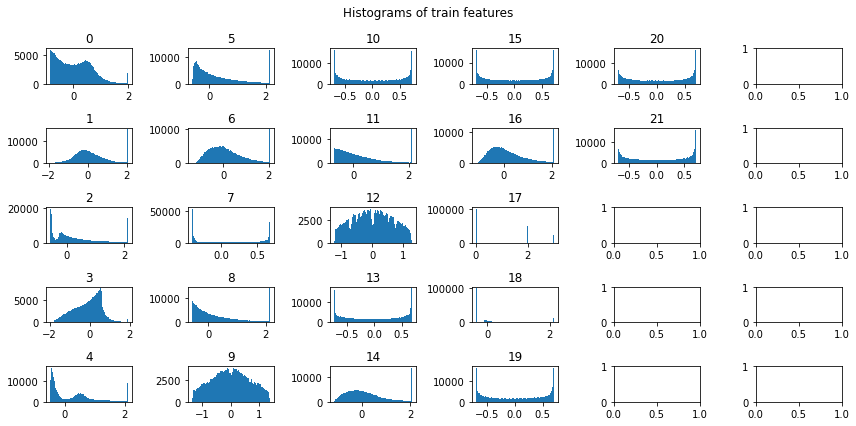

After pre-processing:
x_tr shape : (250000, 22)
x_te shape : (568238, 22)
x_tr range :-1.9839270199826242 3.0
x_te range :-1.9659982563208365 3.0


In [16]:
# Plot features after pre-processing
fig, axs = plt.subplots(5, 6, sharex=False, sharey=False, figsize=(12, 6))

fig.suptitle("Histograms of train features")

# Don't select nan values
for col_idx in range(x_tr.shape[1]):
    subplt = axs[col_idx % 5, math.floor(col_idx / 5)]

    col = x_tr[:, col_idx]
    subplt.hist(col[~np.isnan(col)], bins=100)
    subplt.set_title(col_idx)

plt.tight_layout()
plt.show()
print("After pre-processing:")
print("x_tr shape : {}".format(x_tr.shape))
print("x_te shape : {}".format(x_te.shape))
print("x_tr range :{} {}".format(np.nanmin(x_tr), np.nanmax(x_tr)))
print("x_te range :{} {}".format(np.nanmin(x_te), np.nanmax(x_te)))